# Определение выразительности для классификации графов

In [1]:
import torch

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def set_seed():
    """
    Задает стартовое значение генератора псевдослучайных
    чисел для воспроизводимости.
    """
    torch.manual_seed(-1)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# печатаем информацию о наборе данных
print(f'Набор данных: {dataset}')
print('-----------------------')
print(f'Количество графов: {len(dataset)}')
print(f'Количество узлов: {dataset[0].x.shape[0]}')
print(f'Количество признаков: {dataset.num_features}')
print(f'Количество классов: {dataset.num_classes}')

2024-01-09 15:09:03.278323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Extracting ./PROTEINS/PROTEINS.zip
Processing...


Набор данных: PROTEINS(1113)
-----------------------
Количество графов: 1113
Количество узлов: 30
Количество признаков: 3
Количество классов: 2


Done!


In [3]:
from torch_geometric.loader import DataLoader

# создаем обучающий, валидационный и тестовый наборы
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Обучающий набор     = {len(train_dataset)} графов')
print(f'Валидационный набор = {len(val_dataset)} графов')
print(f'Tестовый набор      = {len(test_dataset)} графов')

# создаем мини-батчи
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nЗагрузчик обучающих данных:')
for i, batch in enumerate(train_loader):
    print(f' - Батч {i}: {batch}')

print('\nЗагрузчик валидационных данных:')
for i, batch in enumerate(val_loader):
    print(f' - Батч {i}: {batch}')

print('\nЗагрузчик тестовых данных:')
for i, batch in enumerate(test_loader):
    print(f' - Батч {i}: {batch}')

Обучающий набор     = 890 графов
Валидационный набор = 111 графов
Tестовый набор      = 112 графов

Загрузчик обучающих данных:
 - Батч 0: DataBatch(edge_index=[2, 10078], x=[2641, 3], y=[64], batch=[2641], ptr=[65])
 - Батч 1: DataBatch(edge_index=[2, 8412], x=[2185, 3], y=[64], batch=[2185], ptr=[65])
 - Батч 2: DataBatch(edge_index=[2, 8240], x=[2117, 3], y=[64], batch=[2117], ptr=[65])
 - Батч 3: DataBatch(edge_index=[2, 11730], x=[3106, 3], y=[64], batch=[3106], ptr=[65])
 - Батч 4: DataBatch(edge_index=[2, 7932], x=[2110, 3], y=[64], batch=[2110], ptr=[65])
 - Батч 5: DataBatch(edge_index=[2, 8716], x=[2346, 3], y=[64], batch=[2346], ptr=[65])
 - Батч 6: DataBatch(edge_index=[2, 8820], x=[2412, 3], y=[64], batch=[2412], ptr=[65])
 - Батч 7: DataBatch(edge_index=[2, 13188], x=[3549, 3], y=[64], batch=[3549], ptr=[65])
 - Батч 8: DataBatch(edge_index=[2, 8268], x=[2209, 3], y=[64], batch=[2209], ptr=[65])
 - Батч 9: DataBatch(edge_index=[2, 8190], x=[2274, 3], y=[64], batch=[2274],

In [4]:
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # эмбеддинги узлов
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # считывание (readout) на уровне графа
        hG = global_mean_pool(h, batch)

        # классификатор
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # эмбеддинги узлов 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # считывание (readout) на уровне графа
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # конкатенируем эмбеддинги графов
        h = torch.cat((h1, h2, h3), dim=1)

        # классификатор
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1)

In [5]:
set_seed()

def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # обучаем на батчах
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # валидируем
            val_loss, val_acc = test(model, val_loader)

        # печатаем метрики через каждые 20 эпох
        if(epoch % 20 == 0):               
            print(f'Эпоха {epoch:>3}:\n| Функция потерь на обуч. наборе: '
                  f'{total_loss:.2f} | Правильность на обуч. наборе: '
                  f'{acc*100:>5.2f}% \n| Функция потерь на валид. '
                  f'наборе: {val_loss:.2f} | Правильность на валид. '
                  f'наборе: {val_acc*100:.2f}%')
            
    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """
    Вычисляем правильность.
    """
    return ((pred_y == y).sum() / len(y)).item()

gcn = GCN(dim_h=32)
gcn = train(gcn, train_loader)
test_loss, test_acc = test(gcn, test_loader)
print(f'Функция потерь на тестовом наборе: {test_loss:.2f} | '
      f'Правильность на тестовом наборе: {test_acc*100:.2f}%')
print()

gin = GIN(dim_h=32)
gin = train(gin, train_loader)
test_loss, test_acc = test(gin, test_loader)
print(f'Функция потерь на тестовом наборе: {test_loss:.2f} | '
      f'Правильность на тестовом наборе: {test_acc*100:.2f}%')

Эпоха   0:
| Функция потерь на обуч. наборе: 0.67 | Правильность на обуч. наборе: 59.80% 
| Функция потерь на валид. наборе: 0.64 | Правильность на валид. наборе: 59.47%
Эпоха  20:
| Функция потерь на обуч. наборе: 0.61 | Правильность на обуч. наборе: 70.75% 
| Функция потерь на валид. наборе: 0.57 | Правильность на валид. наборе: 76.36%
Эпоха  40:
| Функция потерь на обуч. наборе: 0.61 | Правильность на обуч. наборе: 70.14% 
| Функция потерь на валид. наборе: 0.57 | Правильность на валид. наборе: 75.23%
Эпоха  60:
| Функция потерь на обуч. наборе: 0.60 | Правильность на обуч. наборе: 71.56% 
| Функция потерь на валид. наборе: 0.57 | Правильность на валид. наборе: 75.52%
Эпоха  80:
| Функция потерь на обуч. наборе: 0.60 | Правильность на обуч. наборе: 69.33% 
| Функция потерь на валид. наборе: 0.55 | Правильность на валид. наборе: 75.23%
Эпоха 100:
| Функция потерь на обуч. наборе: 0.60 | Правильность на обуч. наборе: 70.32% 
| Функция потерь на валид. наборе: 0.55 | Правильность на ва

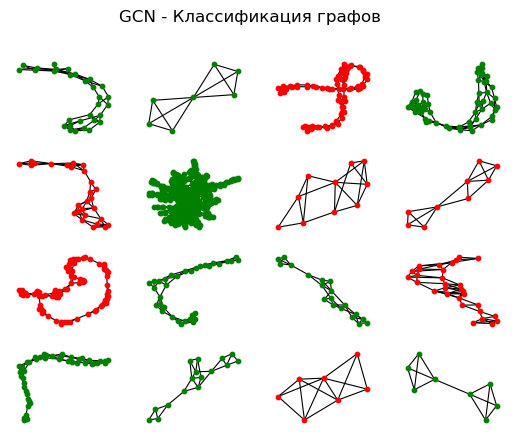

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4)
fig.suptitle('GCN - Классификация графов')

for i, data in enumerate(dataset[-16:]):
    # вычисляем цвет (зеленый, если правильно, 
    # красный в противном случае)
    out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # визуализируем графы
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=False,
                     node_size=10,
                     node_color=color,
                     width=0.8,
                     ax=ax[ix]
                    )

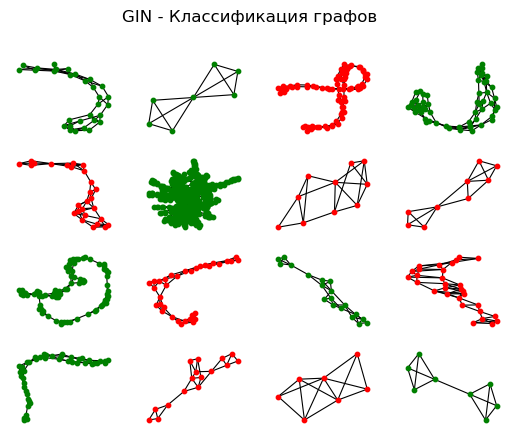

In [7]:
fig, ax = plt.subplots(4, 4)
fig.suptitle('GIN - Классификация графов')

for i, data in enumerate(dataset[-16:]):
    # вычисляем цвет (зеленый, если правильно, 
    # красный в противном случае)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # визуализируем графы
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=False,
                     node_size=10,
                     node_color=color,
                     width=0.8,
                     ax=ax[ix]
                    )

In [8]:
# задаем режим оценки
gcn.eval()
gin.eval()

# сюда записываем значения правильности
acc_gcn = 0
acc_gin = 0
acc_ens = 0

for data in test_loader:
    # получаем результаты классификации
    out_gcn = gcn(data.x, data.edge_index, data.batch)
    out_gin = gin(data.x, data.edge_index, data.batch)
    out_ens = (out_gcn + out_gin)/2

    # вычисляем значения правильности
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)

# печатаем результаты
print(f'GCN правильность:     {acc_gcn*100:.2f}%')
print(f'GIN правильность:     {acc_gin*100:.2f}%')
print(f'GCN+GIN правильность: {acc_ens*100:.2f}%')

GCN правильность:     74.22%
GIN правильность:     70.31%
GCN+GIN правильность: 70.83%
